# Прогноз трафика на базовых станциях

In [1]:
gpu = False

# подключаем библиотеку функций для оптимизации работы с моделями
# https://github.com/alukyantsev/magic_ds/
from magic_ds_20211214 import *
from magic_ds_20211214.ml import *
if not gpu:
    from magic_ds_20211214.ml.sklearnex import *

# подключаем модели
from magic_ds.ml.model_boost import *

%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from psutil import virtual_memory
print(virtual_memory().total / 1e9)

16.395169792


In [3]:
if gpu:
    !nvidia-smi

### Считываем данные

In [6]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test  = pd.read_csv('test_public.csv', index_col=0)

In [7]:
# исключаем все колонки, которые есть в тестовой выборке, но нет в тренировочной
# также исключаем столбцы, в которых в тренировjчной выборке всегда одно значение
col_exclude_list = ['col_n10', 'col_n24', 'col_n36', 'col_n42', 'col_n56']
col_list = list(set(df_train.columns) & set(df_test.columns) - set(col_exclude_list))
col_list.sort()

In [8]:
# формируем единый датасет
df = pd.concat( [ df_train[col_list + ['mb']], df_test[col_list] ] ).reset_index(drop=True)

In [9]:
# сохраняем в словарь
d, d['test'] = {}, {}
d['test']['df'] = df_test[['id2', 'place_id', 'time_idx']]
split_dict_struct(d)

==================== Structure =====================

test -> df


### Изучаем и обрабатываем датасет

In [10]:
df_analyze = df[ df['mb'].map(lambda x: ~np.isnan(x)) ]
df_analyze

,col_n00,col_n01,col_n06,col_n09,col_n11,col_n12,col_n15,col_n17,col_n21,col_n27,col_n32,col_n33,col_n35,col_n38,col_n39,col_n40,col_n41,col_n43,col_n46,col_n47,col_n49,col_n54,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74,id2,place_id,time_idx,mb
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,8,0.02
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,9,0.79
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,10,0.75
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.18,0.00,5,0,11,0.85
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.18,0.00,5,0,12,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860745,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.12,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.04,0.00,0.18,0.00,2,14604,39,0.53
860746,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,2,14604,40,0.53
860747,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,5,14604,40,0.51
860748,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,2,14604,41,0.62


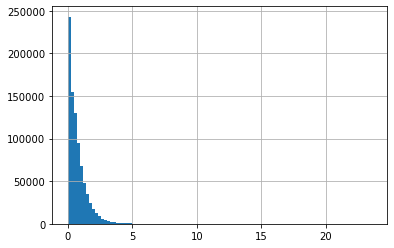

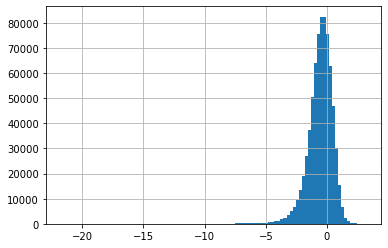

In [11]:
# смотрим распределение целевой переменной
df_analyze['mb'].hist(bins=100)
plt.show()
df_analyze['mb'].map(lambda x: np.log(x) if x>0 else np.nan).hist(bins=100)
plt.show()

In [12]:
analyze_unique(df_analyze, ['time_idx', 'place_id', 'id2'])

==================== time_idx (42 unique) ====================
41    21674
40    21608
39    21585
36    21576
38    21573
35    21571
37    21570
32    21564
31    21563
34    21562
29    21562
30    21560
33    21559
28    21374
27    21322
26    21269
25    21180
24    21133
23    21077
22    21016
21    20962
20    20925
19    20887
18    20870
17    20868
16    20398
15    20150
14    19856
13    19716
12    19600
11    19530
10    19399
9     19293
8     19190
7     19090
6     19061
5     19059
4     18758
3     18676
2     18601
1     18514
0     18449
Name: time_idx, dtype: int64 

==================== place_id (12458 unique) ====================
6037     210
13297    210
10624    210
608      210
5526     210
        ... 
3660       1
11315      1
8146       1
11055      1
10038      1
Name: place_id, Length: 12458, dtype: int64 

==================== id2 (5 unique) ====================
5    460389
0    220658
2    110773
4     45154
6     23776
Name: id2, dtype: int64 



In [13]:
df_analyze[ (df_analyze['place_id'] == 13297) & (df_analyze['id2'] == 2) ]

,col_n00,col_n01,col_n06,col_n09,col_n11,col_n12,col_n15,col_n17,col_n21,col_n27,col_n32,col_n33,col_n35,col_n38,col_n39,col_n40,col_n41,col_n43,col_n46,col_n47,col_n49,col_n54,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74,id2,place_id,time_idx,mb
785408,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.03,0.58,0.00,0.00,0.06,2,13297,0,0.00
785413,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.79,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.03,0.64,0.00,0.00,0.06,2,13297,1,0.00
785420,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.85,0.24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.03,0.69,0.00,0.00,0.06,2,13297,2,0.00
785426,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.91,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.03,0.75,0.00,0.00,0.06,2,13297,3,0.00
785430,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.94,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.03,0.00,0.00,0.06,0.77,0.00,0.00,0.09,2,13297,4,0.00
785435,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.06,0.81,0.00,0.00,0.09,2,13297,5,0.00
785440,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.06,0.81,0.00,0.00,0.09,2,13297,6,0.00
785444,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.06,0.83,0.00,0.00,0.09,2,13297,7,0.00
785451,0.00,0.00,0.00,0.00,0.00,0.51,0.00,1.03,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.04,0.06,0.00,0.00,0.06,0.91,0.17,0.00,0.09,2,13297,8,0.00
785456,0.00,0.00,0.00,0.00,0.00,8.41,0.00,1.03,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.70,0.00,0.06,0.25,0.00,0.00,0.00,0.04,1.00,0.00,0.00,0.06,0.89,0.12,0.00,0.09,2,13297,9,0.01


In [14]:
df_analyze[ (df_analyze['place_id'] == 13297) & (df_analyze['time_idx'] == 40) ]

,col_n00,col_n01,col_n06,col_n09,col_n11,col_n12,col_n15,col_n17,col_n21,col_n27,col_n32,col_n33,col_n35,col_n38,col_n39,col_n40,col_n41,col_n43,col_n46,col_n47,col_n49,col_n54,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74,id2,place_id,time_idx,mb
785608,0.00,0.00,0.00,0.00,0.00,15.03,0.00,1.18,0.94,0.25,0.00,0.00,0.00,0.00,0.03,0.09,1.75,0.00,0.06,0.76,0.00,0.00,0.00,0.04,1.78,0.00,0.00,0.06,1.25,0.23,0.00,0.09,0,13297,40,0.71
785609,0.00,0.00,0.00,0.00,0.00,15.03,0.00,1.18,0.94,0.25,0.00,0.00,0.00,0.00,0.03,0.09,0.00,0.00,0.06,0.76,0.00,0.00,0.00,0.04,1.78,0.00,0.00,0.06,1.25,0.23,0.00,0.09,4,13297,40,0.00
785610,0.00,0.00,0.00,0.00,0.00,15.03,0.00,1.18,0.94,0.25,0.00,0.00,0.00,0.00,0.03,0.09,0.35,0.00,0.06,0.76,0.00,0.00,0.00,0.04,1.78,0.00,0.00,0.06,1.25,0.23,0.00,0.09,6,13297,40,0.21
785611,0.00,0.00,0.00,0.00,0.00,15.03,0.00,1.18,0.94,0.25,0.00,0.00,0.00,0.00,0.03,0.09,0.00,0.00,0.06,0.76,0.00,0.00,0.00,0.04,1.78,0.00,0.00,0.06,1.25,0.23,0.00,0.09,5,13297,40,0.00
785612,0.00,0.00,0.00,0.00,0.00,15.03,0.00,1.18,0.94,0.25,0.00,0.00,0.00,0.00,0.03,0.09,0.70,0.00,0.06,0.76,0.00,0.00,0.00,0.04,1.78,0.00,0.00,0.06,1.25,0.23,0.00,0.09,2,13297,40,0.73


In [15]:
df_analyze[ (df_analyze['id2'] == 6) & (df_analyze['time_idx'] == 2) ].head(50)

,col_n00,col_n01,col_n06,col_n09,col_n11,col_n12,col_n15,col_n17,col_n21,col_n27,col_n32,col_n33,col_n35,col_n38,col_n39,col_n40,col_n41,col_n43,col_n46,col_n47,col_n49,col_n54,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74,id2,place_id,time_idx,mb
2163,0.00,0.00,0.15,0.00,0.00,0.00,0.00,2.30,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.97,0.00,0.00,0.48,0.00,0.00,0.97,0.00,0.06,3.71,0.00,0.00,0.09,1.62,0.00,3.72,0.68,6,34,2,0.00
7287,0.00,0.00,0.09,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.18,0.00,0.00,0.00,0.00,0.00,0.18,0.00,0.00,0.27,0.00,0.00,0.00,0.00,0.00,0.24,0.00,6,124,2,0.00
8540,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6,143,2,0.00
10743,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.04,0.00,0.09,0.00,6,183,2,0.06
11373,0.00,0.00,0.00,0.00,0.00,4.33,0.00,0.59,0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.51,0.00,0.00,0.00,0.56,0.00,0.00,0.00,6,195,2,0.00
14968,0.00,0.00,0.00,0.00,0.00,0.51,0.00,0.00,0.00,0.51,0.00,0.00,0.00,0.00,0.06,0.06,0.35,0.00,0.00,0.51,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6,252,2,0.22
16890,0.00,0.00,0.00,0.00,0.00,16.82,0.00,1.21,0.00,4.33,0.00,0.00,0.00,0.00,0.51,1.18,0.35,0.00,0.58,9.94,0.00,0.00,0.00,0.25,1.99,0.00,0.00,0.35,0.85,0.00,0.00,0.82,6,290,2,0.37
18193,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.00,0.03,0.00,6,316,2,0.27
19878,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,6,346,2,0.00
25086,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,1.15,0.00,0.00,0.00,0.19,0.00,1.15,0.00,6,431,2,0.00


In [16]:
# добавляем поле среднее по id
mean_id = df_analyze.groupby(by=['id2']).mean()['mb']
df['mean_id_mb'] = df.drop('mb', axis=1).join(mean_id, on=['id2'], how='left')['mb']

# добавляем поле среднее по place
mean_place = df_analyze.groupby(by=['place_id']).mean()['mb']
df['mean_place_mb'] = df.drop('mb', axis=1).join(mean_place, on=['place_id'], how='left')['mb']

replace_arr = df[ df['mean_place_mb'].map(lambda x: np.isnan(x)) ]['mean_place_mb']
for i in replace_arr.index:
    df.loc[ df.index == i, 'mean_place_mb' ] = df.iloc[i]['mean_id_mb']

# добавляем поле среднее по place+id
mean_place_id = df_analyze.groupby(by=['place_id', 'id2']).mean()['mb']
df['mean_place_id_mb'] = df.drop('mb', axis=1).join(mean_place_id, on=['place_id', 'id2'], how='left')['mb']

replace_arr = df[ df['mean_place_id_mb'].map(lambda x: np.isnan(x)) ][['mean_place_id_mb', 'mean_id_mb']]
for i in replace_arr.index:
    df.loc[ df.index == i, 'mean_place_id_mb' ] = df.iloc[i]['mean_id_mb']

In [17]:
# прологарифмируем mb
df['mb_log'] = np.log(df['mb'] + 1e-15)
df.drop(columns=['mb'], inplace=True)

In [18]:
df

,col_n00,col_n01,col_n06,col_n09,col_n11,col_n12,col_n15,col_n17,col_n21,col_n27,col_n32,col_n33,col_n35,col_n38,col_n39,col_n40,col_n41,col_n43,col_n46,col_n47,col_n49,col_n54,col_n58,col_n60,col_n61,col_n62,col_n64,col_n69,col_n70,col_n71,col_n73,col_n74,id2,place_id,time_idx,mean_id_mb,mean_place_mb,mean_place_id_mb,mb_log
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,8,0.86,1.54,1.54,-3.90
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,9,0.86,1.54,1.54,-0.24
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.15,0.00,0.00,0.00,0.00,0.00,0.15,0.00,5,0,10,0.86,1.54,1.54,-0.28
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.18,0.00,5,0,11,0.86,1.54,1.54,-0.16
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,1.05,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.18,0.00,0.00,0.00,0.00,0.00,0.18,0.00,5,0,12,0.86,1.54,1.54,-0.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121935,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,5,14604,51,0.86,0.30,0.44,NaN
1121936,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,5,14604,52,0.86,0.30,0.44,NaN
1121937,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,2,14604,52,0.40,0.30,0.16,NaN
1121938,0.00,0.00,0.06,0.00,0.12,0.00,0.00,0.00,0.18,0.00,0.00,0.12,0.00,0.00,0.06,0.06,0.70,0.00,0.04,0.00,0.00,0.06,0.00,0.04,0.18,0.00,0.00,0.00,0.06,0.00,0.18,0.00,5,14604,53,0.86,0.30,0.44,NaN


In [19]:
gap_info(df)

Your selected dataframe has 39 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
mb_log,261190,23.30


In [26]:
visualize_corr(df, size=(80,40))

![](./images/corr.png)

### Готовим выборку

In [21]:
# разбиваем датафрейм на выборки
d['original_mean_log'] = split_df(
    df, 'mb_log', prc_train=85, prc_valid=15, prc_test=0,
    target_test_value=np.nan, random_state=42
)

In [22]:
np.save('./d.npy', d)
#d = np.load('./d.npy', allow_pickle='TRUE').item()
split_dict_struct(d)

==================== Structure =====================

test -> df

original_mean_log -> X_train
original_mean_log -> X_valid
original_mean_log -> X_test
original_mean_log -> y_train
original_mean_log -> y_valid


In [23]:
# выводим список топ колонок, влияющих на целевую переменную через eli5
model_eli5 = select_eli5(
    pd.concat([ d['original_mean_log']['X_train'], d['original_mean_log']['X_valid'] ]),
    pd.concat([ d['original_mean_log']['y_train'], d['original_mean_log']['y_valid'] ]),
    xgb.XGBRegressor(**param_XGBRegressor),
    scoring=smape
)

Weight,Feature
0.9941,col_n41
0.0035,mean_place_id_mb
0.0005,time_idx
0.0004,id2
0.0004,mean_place_mb
0.0002,mean_id_mb
0.0001,col_n35
0.0001,col_n70
0.0001,col_n61
0.0001,col_n46


Weight,Feature
2.7899 ± 0.5121,mean_place_id_mb
2.0755 ± 7.2029,col_n41
1.3795 ± 0.7693,time_idx
0.6851 ± 1.8998,id2
0.6038 ± 1.1403,col_n46
0.5518 ± 0.7829,col_n61
0.5232 ± 1.9666,mean_place_mb
0.2573 ± 0.7776,col_n17
0.2195 ± 0.5083,col_n21
0.2131 ± 0.2570,col_n74


### Определяем лучшую модель и источник данных и усиленно ее тренируем

In [24]:
# LGBMRegressor - original_mean_log
estimator = lgb.LGBMRegressor
param_grid = locals()['params_' + estimator.__name__]
param_grid = {
    'max_depth':[9, 11, 13],
    'n_estimators':[500, 800, 1000],
    'min_child_weight':[5],
    'learning_rate':[0.1],
    'random_state': [42]
}
if gpu:
    param_grid = {
        **param_grid,
        **{ 'device': ['gpu'] }
    }

for i in tqdm([0]):
    d['original_mean_log'][estimator.__name__] = model_fit(
        estimator, param_grid,
        d['original_mean_log']['X_train'], d['original_mean_log']['y_train'],
        d['original_mean_log']['X_valid'], d['original_mean_log']['y_valid'],
        d['original_mean_log']['X_test'],
        result=4, scoring=smape, learning_curves_dots=0
    )
eli5.explain_weights(d['original_mean_log'][estimator.__name__]['model'], top=20)

  0%|          | 0/1 [00:00<?, ?it/s]

==================== Stage 1: train ====================

Best estimator: LGBMRegressor(max_depth=11, min_child_weight=5, n_estimators=1000,
              random_state=42)
Best train score: 0.851909 make_scorer(smape_error, greater_is_better=False) using {'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 5, 'n_estimators': 1000, 'random_state': 42}

==================== Stage 2: valid ====================

Best valid score: 0.830966 using {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 800, 'random_state': 42}



100%|██████████| 1/1 [27:13<00:00, 1633.85s/it]


Weight,Feature
0.9948,col_n41
0.0037,mean_place_id_mb
0.0007,time_idx
0.0003,id2
0.0001,mean_place_mb
0.0000,mean_id_mb
0.0000,col_n61
0.0000,col_n70
0.0000,col_n17
0.0000,col_n71


In [25]:
# сохраняем предикт
output = pd.DataFrame({
    'time_idx': d['test']['df']['time_idx'].values,
    'place_id': d['test']['df']['place_id'].values,
    'id2': d['test']['df']['id2'].values,
    'mb': (np.exp(d['original_mean_log']['LGBMRegressor']['y_pred']) - 1e-15)
}, index=d['test']['df'].index)
save_csv(output, path='./', name='lgbm_original_mean_log', index=True)

In [6]:
# CatBoostRegressor - original_mean_log
# для работы CatBoost с GPU необходимо в функцию model_fit передать n_jobs=1
estimator = ctb.CatBoostRegressor
param_grid = locals()['params_' + estimator.__name__]
param_grid = {
    'max_depth':[9, 11],
    'n_estimators':[500, 800],
    'learning_rate':[0.1],
    'random_state': [42],
    'verbose': [0]
}
if gpu:
    param_grid = {
        **param_grid,
        **{ 'task_type': ['GPU'] }
    }

for i in tqdm([0]):
    d['original_mean_log'][estimator.__name__] = model_fit(
        estimator, param_grid,
        d['original_mean_log']['X_train'], d['original_mean_log']['y_train'],
        d['original_mean_log']['X_valid'], d['original_mean_log']['y_valid'],
        d['original_mean_log']['X_test'],
        result=2, scoring=smape, cv=5, learning_curves_dots=0, n_jobs=(1 if gpu else 4)
    )
eli5.explain_weights(d['original_mean_log'][estimator.__name__]['model'], top=20)

  0%|          | 0/1 [00:00<?, ?it/s]

==================== Stage 1: train ====================

Best estimator: <catboost.core.CatBoostRegressor object at 0x7f3541569310>
Best train score: 0.975365 make_scorer(smape_error, greater_is_better=False) using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 800, 'random_state': 42, 'verbose': 0}

==================== Stage 2: valid ====================

Best valid score: 0.670203 using {'learning_rate': 0.1, 'max_depth': 11, 'n_estimators': 500, 'random_state': 42, 'verbose': 0}



100%|██████████| 1/1 [1:23:33<00:00, 5013.66s/it]


Weight,Feature
0.9926,col_n41
0.0029,mean_place_id_mb
0.0013,mean_place_mb
0.0012,time_idx
0.0004,id2
0.0003,mean_id_mb
0.0001,col_n70
0.0001,col_n61
0.0001,col_n73
0.0001,col_n71


In [7]:
# сохраняем предикт
output = pd.DataFrame({
    'time_idx': d['test']['df']['time_idx'].values,
    'place_id': d['test']['df']['place_id'].values,
    'id2': d['test']['df']['id2'].values,
    'mb': (np.exp(d['original_mean_log']['CatBoostRegressor']['y_pred']) - 1e-15)
}, index=d['test']['df'].index)
save_csv(output, path='./', name='ctb_original_mean_log', index=True)

In [8]:
# xgb.XGBRegressor - original_mean_log
estimator = xgb.XGBRegressor
param_grid = locals()['params_' + estimator.__name__]
param_grid = {
    'max_depth':[9],
    'n_estimators':[800, 1000],
    'learning_rate':[0.1],
    'random_state': [42]
}
if gpu:
    param_grid = {
        **param_grid,
        **{ 'tree_method': ['gpu_hist'], 'gpu_id': [0] }
    }

for i in tqdm([0]):
    d['original_mean_log'][estimator.__name__] = model_fit(
        estimator, param_grid,
        d['original_mean_log']['X_train'], d['original_mean_log']['y_train'],
        d['original_mean_log']['X_valid'], d['original_mean_log']['y_valid'],
        d['original_mean_log']['X_test'],
        result=2, scoring=smape, learning_curves_dots=0
    )
eli5.explain_weights(d['original_mean_log'][estimator.__name__]['model'], top=20)

  0%|          | 0/1 [00:00<?, ?it/s]

==================== Stage 1: train ====================

Best estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=800, n_jobs=4, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best train score: 0.797933 make_scorer(smape_error, greater_is_better=False) using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 800, 'random_state': 42}

==================== Stage 2: valid ====================

Best valid score: 0.641620 using {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000, 'random_state': 42}



100%|██████████| 1/1 [3:44:24<00:00, 13464.60s/it]


Weight,Feature
0.9902,col_n41
0.0043,mean_place_id_mb
0.0009,id2
0.0005,mean_id_mb
0.0004,time_idx
0.0003,col_n71
0.0002,col_n64
0.0002,mean_place_mb
0.0002,col_n73
0.0002,col_n38


In [9]:
# сохраняем предикт
output = pd.DataFrame({
    'time_idx': d['test']['df']['time_idx'].values,
    'place_id': d['test']['df']['place_id'].values,
    'id2': d['test']['df']['id2'].values,
    'mb': (np.exp(d['original_mean_log']['XGBRegressor']['y_pred']) - 1e-15)
}, index=d['test']['df'].index)
save_csv(output, path='./', name='xgb_original_mean_log', index=True)

In [10]:
np.save('./d.npy', d)
#d = np.load('./d.npy', allow_pickle='TRUE').item()
split_dict_struct(d)

==================== Structure =====================

test -> df

original_mean_log -> X_train
original_mean_log -> X_valid
original_mean_log -> X_test
original_mean_log -> y_train
original_mean_log -> y_valid
original_mean_log -> LGBMRegressor
original_mean_log -> LGBMRegressor -> model
original_mean_log -> LGBMRegressor -> y_pred
original_mean_log -> LGBMRegressor -> y_valid_pred
original_mean_log -> CatBoostRegressor
original_mean_log -> CatBoostRegressor -> model
original_mean_log -> CatBoostRegressor -> y_pred
original_mean_log -> CatBoostRegressor -> y_valid_pred
original_mean_log -> XGBRegressor
original_mean_log -> XGBRegressor -> model
original_mean_log -> XGBRegressor -> y_pred
original_mean_log -> XGBRegressor -> y_valid_pred
